## Simulation-Based Inference SIR Model: Training (critical value)
Created: Jan 10, 2024 Ali Al Kadhim and Harrison B. Prosper<br>
This is a based on 2_SIR_train_cdf.ipynb

### Introduction 

The purpose of this notebook is to approximate the quantile function $\lambda = \text{cdf}^{-1}(\tau | \theta)$, that is, the inverse function of the cumulative distribution function $\tau = \text{cdf}(\lambda | \theta)$, where in this context $\tau$ is the confidence level. 

Our test statistic $\lambda$  is large for parameters $\theta$ *disfavored* by the data, therefore, a confidence set at whereas in the algorithm of Ref.[1], a modified version of which we use, $\lambda$ is small for disfavored parameters. Therefore, we're approximating the cumulative distribution function (cdf) rather than the p-value. 

The stochastic forward simulator $F_\theta$ is the CTMC simulator in notebook SIR_generate_data.ipynb, which simulates the ensemble of synthetic epidemics.

### References
  1. Ann Lee *et al.*, https://arxiv.org/abs/2107.03920

In [2]:
import os, sys

sys.path.append('../')

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# standard scientific python module
import scipy as sp
import scipy.stats as st
import scipy.optimize as op

# module to save results
#import joblib as jb

# pytorch
import torch
import torch.nn as nn

# split data into a training set and a test set
from sklearn.model_selection import train_test_split

# to reload modules
import importlib

import SIR_dnn_util as ut
from SIR_gen_util import Fsolve, test_statistic, SIRdata

%matplotlib inline

device: cpu


In [3]:
# update fonts
FONTSIZE = 18
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

device = ut.device

### Load data

__Note__: The $\alpha$ and $\beta$ parameters have been scaled so that they are of $\cal{O}(1)$. Therefore, no further transformation is needed.

In [10]:
print('SIRdata')
data = SIRdata
data.alpha_min,  data.alpha_max = 0.10, 0.90
data.beta_min,   data.beta_max  = 0.25, 0.65
print(data)
print()

DSIZE = '100k'

datafile = f'../data/SIR_traindata_{DSIZE:s}.csv.gz'

print('loading %s' % datafile)
df = pd.read_csv(datafile)
df['tau'] = np.random.uniform(0, 1, len(df))
print('number of rows:', len(df))

df[:5]

SIRdata
 D           : [  3  25  75 227 296 258 236 192 126  71  28  11   7]
 I0          : 3
 O           : [  3  25  75 227 296 258 236 192 126  71  28  11   7]
 R0          : 0
 S0          : 763
 T           : [ 0  2  3  4  5  6  7  8  9 10 11 12 13]
 alpha0      : 0.465
 alpha_bins  : 10
 alpha_max   : 0.9
 alpha_min   : 0.1
 alpha_scale : 1.0
 beta0       : 0.00237
 beta_bins   : 10
 beta_max    : 0.65
 beta_min    : 0.25
 beta_scale  : 0.005
 model       : SIR
 scale       : 50
 tmax        : 14.0
 tmin        : 0.0


loading ../data/SIR_traindata_100k.csv.gz
number of rows: 100000


,alpha,beta,li,lo,l0,Zo,Z0,i,I,tau
0,0.556824,0.432547,0.017546,0.455190,0.068463,1.0,1.0,"[3, 13, 65, 134, 222, 229, 200, 153, 99, 69, 4...","[3.0, 25.41, 66.24, 140.76, 212.17, 226.2, 190...",0.107794
1,0.917183,0.617733,0.110494,0.172180,0.323215,1.0,1.0,"[3, 3, 27, 71, 151, 170, 106, 63, 42, 20, 8, 4...","[3.0, 46.43, 126.68, 188.65, 160.33, 101.22, 5...",0.831288
2,0.222595,0.684092,0.020499,0.309478,0.178384,1.0,1.0,"[3, 286, 527, 507, 413, 337, 273, 222, 172, 14...","[3.0, 232.07, 521.39, 511.27, 423.76, 341.88, ...",0.313061
3,0.513685,0.231400,0.054771,1.783674,0.630670,1.0,1.0,"[3, 4, 6, 2, 5, 8, 7, 13, 29, 44, 50, 67, 85]","[3.0, 6.22, 8.89, 12.59, 17.59, 24.14, 32.47, ...",0.809292
4,0.533168,0.343659,0.057785,0.553024,0.198700,1.0,1.0,"[3, 20, 41, 85, 160, 186, 172, 156, 124, 90, 6...","[3.0, 13.87, 28.69, 55.72, 97.06, 143.04, 172....",0.527562


In [11]:
def plot_data(d, filename='../images/fig_SIR_flu_data.pdf', fgsize=(5, 4), ftsize=14):
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fgsize)
    
    # pad
    #plt.subplots_adjust(hspace=0.01)
    #plt.subplots_adjust(wspace=0.3)

    #
    xmin, xmax = 0,  18
    ymin, ymax = 0, 400

    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(r'$t$ (day)', fontsize=ftsize)
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(r'infected (count)', fontsize=ftsize)
    
    ax.scatter(d.T, d.D, s=20, c='black', 
               label=r'number of individuals in class $I$')
    ax.legend(fontsize=14)
               
    ax.grid() 
    
    plt.tight_layout()
    plt.savefig(filename)
    print(filename)

../images/fig_SIR_flu_data.pdf


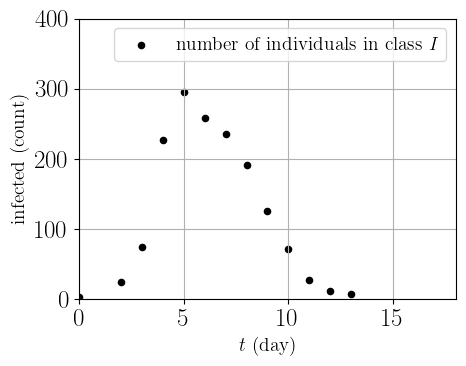

In [12]:
plot_data(SIRdata)

### Train, validation, and test sets
There is some confusion in terminology regarding validation and test samples (or sets). We shall adhere to the defintions given here https://machinelearningmastery.com/difference-test-validation-datasets/):
   
  * __Training Dataset__: The sample of data used to fit the model.
  * __Validation Dataset__: The sample of data used to decide 1) whether the fit is reasonable (e.g., the model has not been overfitted), 2) decide which of several models is the best and 3) tune model hyperparameters.
  * __Test Dataset__: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

The validation set will be some small fraction of the training set and can be used, for example, to decide when to stop the training.

train set size:         80000
validation set size:     5000
test set size:          15000
    0
saved to file: fig_cset_by_hist.png


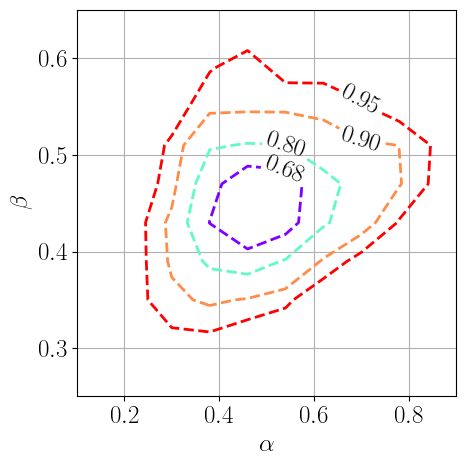

In [13]:
# Fraction of the data assigned as test data and validation
tfraction = 1.5/10 # test fraction, rest for training
vfraction = 5/85
tdata     = df

SIRdata.alpha_bins = 10
SIRdata.beta_bins  = 10

# Split data into a part for training and a part for testing
train_data, valid_data, test_data = ut.split_data(df, 
                                         test_fraction=tfraction, 
                                         validation_fraction=vfraction) 

print('train set size:        %6d' % train_data.shape[0])
print('validation set size:   %6d' % valid_data.shape[0])
print('test set size:         %6d' % test_data.shape[0])

def smooth_hist(tfraction=2/3, K=1, d=SIRdata):
    P = np.zeros((data.alpha_bins, d.beta_bins))
    for k in range(K):
        print('\r%5d' % k, end='')
        _, test   = train_test_split(df, 
                                 test_size=tfraction, 
                                 shuffle=True)
        p, xe, ye = ut.hist_data(test, SIRdata)
        P += p
    print()
    P /= K
    return P, xe, ye

hist = smooth_hist()

ut.plot_model(tdata, SIRdata, filename='fig_cset_by_hist.png')

### Empirical risk (that is, average loss)

The empirical risk, which is the __objective function__ we shall minimize, is defined by

\begin{align}
R_M(\theta) & = \frac{1}{M} \sum_{m=1}^{M} L(t_m, f_m),
\end{align}

where 

\begin{align*}
    f_m & \equiv f(\mathbf{x}_m, \theta).
\end{align*}

The empirical risk $R_M$ approximates the __risk functional__

\begin{align}
R[f] & = \int \cdots \int \, p(t, \mathbf{x}) \, L(t, f(\mathbf{x}, \theta)) \, dt \, d\mathbf{x} .
\end{align}

The quantity $p(t, \mathbf{x}) \, dt\, d\mathbf{x}$ is the probability distribution from which the sample $\{ (t_m, \mathbf{x}_m), m = 1,\cdots, M \}$ is presumed to have been drawn. 

We use the __quantile loss__

$$
    L{\tau}(t, f) \begin{align}
    &=
    \begin{cases}
        \tau (t - f ), \qquad & \text{if } t > f \\
         (1-\tau) (f - t), \qquad &\text{otherwise}
    \end{cases}
    \end{align}
$$

### Define model $C(\alpha, \beta, \tau; \omega)$

For simple models, it is sufficient to use the __Sequential__ class.

In [16]:
%%writefile ../models/SIR_dnn_quantile_100k.py

name     = f'SIR_dnn_quantile_100k'
features = ['alpha', 'beta', 'tau']
target   = 'li'
nodes    = 25

import torch
import torch.nn as nn

model = nn.Sequential(nn.Linear( len(features), nodes),
                      nn.ReLU(),
                      
                      nn.Linear(nodes, nodes),
                      nn.ReLU(),
                      
                      nn.Linear(nodes, nodes),
                      nn.ReLU(), 
                      
                      nn.Linear(nodes, nodes),
                      nn.ReLU(),                    
                      
                      nn.Linear(nodes, nodes),
                      nn.ReLU(), 
                      
                      nn.Linear(nodes, nodes),
                      nn.ReLU(),                    

                      nn.Linear(nodes, 1)
                     )

Overwriting ../models/SIR_dnn_quantile_100k.py


In [17]:
import models.SIR_dnn_quantile_100k as NN
importlib.reload(NN)
name     = NN.name
model    = NN.model.to(device)
features = NN.features
target   = NN.target
modelfile  = '../models/%s.dict' % NN.name
print(name)
print(model)
print('number of parameters: %d' % ut.number_of_parameters(model))

SIR_dnn_quantile_100k
Sequential(
  (0): Linear(in_features=3, out_features=25, bias=True)
  (1): ReLU()
  (2): Linear(in_features=25, out_features=25, bias=True)
  (3): ReLU()
  (4): Linear(in_features=25, out_features=25, bias=True)
  (5): ReLU()
  (6): Linear(in_features=25, out_features=25, bias=True)
  (7): ReLU()
  (8): Linear(in_features=25, out_features=25, bias=True)
  (9): ReLU()
  (10): Linear(in_features=25, out_features=25, bias=True)
  (11): ReLU()
  (12): Linear(in_features=25, out_features=1, bias=True)
)
number of parameters: 3376


### Train!

In [18]:
traces = ([], [], [])
traces_step = 10

In [19]:
n_batch       = 50
n_iterations  = 1000000
early_stopping= 100000
learning_rate = 1.e-3

optimizer     = torch.optim.Adam(model.parameters(), 
                                 lr=learning_rate) 

traces = ut.train(model, optimizer, 
                  modelfile, early_stopping,
                  ut.average_quantile_loss,
                  ut.get_batch, 
                  train_data, valid_data,
                  features, target,
                  n_batch, 
                  n_iterations,
                  traces,
                  step=traces_step)

n_batch       = 500
n_iterations  = 50000
early_stopping= 2000
learning_rate = 1.e-4

traces = ut.train(model, optimizer, 
                  modelfile, early_stopping,
                  ut.average_quantile_loss,
                  ut.get_batch, 
                  train_data, valid_data,
                  features, target,
                  n_batch, 
                  n_iterations,
                  traces,
                  step=traces_step)



Iteration vs average loss
iteration train-set valid-set
0        0 0.0478387 0.0485422
10       10 0.0180912 0.0183987
20       20 0.0163603 0.0164124
30       30 0.0153535 0.0154622
40       40 0.0152156 0.0154301
476130120 0.0101548 0.0102454    476120:    376120/0.01020757/   100000

stopping early!

Iteration vs average loss
iteration train-set valid-set
201078130 0.0101384 0.0102155      2000:         0/0.01020702/     2000

stopping early!



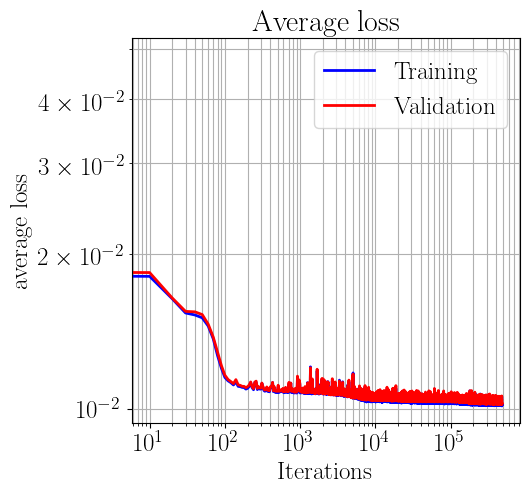

In [20]:
ut.plot_average_loss(traces)

In [21]:
Load_model = True
print('load model: %s' % modelfile)

if Load_model:
    modeldict = torch.load(modelfile)
    NN.model.load_state_dict(modeldict)

load model: ../models/SIR_dnn_quantile_100k.dict


In [22]:
def quantile(x, y, z):
    X = np.array([x, y, z]).T
    inputs = torch.Tensor(X)
    # go to evaluation mode
    model.eval()
    
    # compute,reshape to a 1d array, and convert to a numpy array
    Y = model(inputs).view(-1,).detach().numpy()
    if len(Y) == 1:
        return Y[0]
    else:
        return Y

In [23]:
CL = 0.68
alpha = df['alpha']
beta  = df['beta']
li    = df['li']
tau   = np.full_like(alpha, CL)

c     = quantile(alpha, beta, tau)
cov   =(li <= c).mean()
print(f'coverage: {cov:5.3f}')

coverage: 0.678
